In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
data=yf.download('^HSI','2020-01-01','2022-01-01')
data.drop('Volume',1,inplace=True)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_15224/4010771603.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('Volume',1,inplace=True)


,Open,High,Low,Close,Adj Close,Prediction
Date,,,,,,
2020-01-02,28249.369141,28543.519531,28245.970703,28543.519531,28543.519531,28451.500000
2020-01-03,28828.359375,28883.300781,28428.169922,28451.500000,28451.500000,28226.189453
2020-01-06,28326.500000,28367.869141,28054.289062,28226.189453,28226.189453,28322.060547
2020-01-07,28352.679688,28473.080078,28264.070312,28322.060547,28322.060547,28087.919922
2020-01-08,27999.580078,28198.609375,27857.730469,28087.919922,28087.919922,28561.000000
...,...,...,...,...,...,...
2021-12-23,23141.789062,23264.750000,23027.150391,23193.640625,23193.640625,23223.759766
2021-12-24,23375.990234,23383.189453,23186.570312,23223.759766,23223.759766,23280.560547
2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547,23086.539062


In [3]:
data_val=data[-100:]
data=data[:-100]

In [4]:
sc = MinMaxScaler(feature_range = (-1, 1))
sc_y= MinMaxScaler(feature_range = (0, 1))

In [5]:
X=sc.fit_transform(data.drop('Prediction',1))
#X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(315, 1, 5) (315,) (79, 1, 5) (79,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_15224/3471942301.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [6]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-10 20:20:46.724993: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-10 20:20:46.725114: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=700,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/700


2022-04-10 20:20:47.172144: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-10 20:20:48.519535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:20:48.735034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:20:48.771333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:20:48.846928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:20:48.909688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 3s 78ms/step - loss: 668591808.0000 - val_loss: 834496128.0000
Epoch 2/700
 1/18 [>.............................] - ETA: 0s - loss: 813832768.0000

2022-04-10 20:20:50.143461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:20:50.227706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:20:50.251747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 12ms/step - loss: 668568128.0000 - val_loss: 834464768.0000
Epoch 3/700
18/18 [==============================] - 0s 13ms/step - loss: 668500864.0000 - val_loss: 834387968.0000
Epoch 4/700
18/18 [==============================] - 0s 13ms/step - loss: 668274688.0000 - val_loss: 834203776.0000
Epoch 5/700
18/18 [==============================] - 0s 12ms/step - loss: 667573056.0000 - val_loss: 833808128.0000
Epoch 6/700
18/18 [==============================] - 0s 15ms/step - loss: 665908096.0000 - val_loss: 832950464.0000
Epoch 7/700
18/18 [==============================] - 0s 11ms/step - loss: 663133120.0000 - val_loss: 830918208.0000
Epoch 8/700
18/18 [==============================] - 0s 11ms/step - loss: 659451776.0000 - val_loss: 826715392.0000
Epoch 9/700
18/18 [==============================] - 0s 11ms/step - loss: 655051840.0000 - val_loss: 820509888.0000
Epoch 10/700
18/18 [==============================] - 0s 11ms/step - loss: 650233920

18/18 [==============================] - 0s 11ms/step - loss: 195164848.0000 - val_loss: 282718144.0000
Epoch 73/700
18/18 [==============================] - 0s 11ms/step - loss: 188438928.0000 - val_loss: 274536896.0000
Epoch 74/700
18/18 [==============================] - 0s 11ms/step - loss: 181834112.0000 - val_loss: 266478608.0000
Epoch 75/700
18/18 [==============================] - 0s 11ms/step - loss: 175353040.0000 - val_loss: 258546512.0000
Epoch 76/700
18/18 [==============================] - 0s 11ms/step - loss: 168998080.0000 - val_loss: 250743424.0000
Epoch 77/700
18/18 [==============================] - 0s 11ms/step - loss: 162771360.0000 - val_loss: 243072080.0000
Epoch 78/700
18/18 [==============================] - 0s 11ms/step - loss: 156674944.0000 - val_loss: 235534976.0000
Epoch 79/700
18/18 [==============================] - 0s 11ms/step - loss: 150710592.0000 - val_loss: 228134432.0000
Epoch 80/700
18/18 [==============================] - 0s 11ms/step - loss: 14

18/18 [==============================] - 0s 12ms/step - loss: 5567254.0000 - val_loss: 19754624.0000
Epoch 143/700
18/18 [==============================] - 0s 11ms/step - loss: 5380065.0000 - val_loss: 19142068.0000
Epoch 144/700
18/18 [==============================] - 0s 12ms/step - loss: 5209846.0000 - val_loss: 18562936.0000
Epoch 145/700
18/18 [==============================] - 0s 11ms/step - loss: 5055301.5000 - val_loss: 18015614.0000
Epoch 146/700
18/18 [==============================] - 0s 11ms/step - loss: 4915212.5000 - val_loss: 17498492.0000
Epoch 147/700
18/18 [==============================] - 0s 12ms/step - loss: 4788429.0000 - val_loss: 17010064.0000
Epoch 148/700
18/18 [==============================] - 0s 11ms/step - loss: 4673877.0000 - val_loss: 16548887.0000
Epoch 149/700
18/18 [==============================] - 0s 11ms/step - loss: 4570546.5000 - val_loss: 16113571.0000
Epoch 150/700
18/18 [==============================] - 0s 11ms/step - loss: 4477497.5000 - val

18/18 [==============================] - 0s 12ms/step - loss: 3773798.7500 - val_loss: 9468618.0000
Epoch 214/700
18/18 [==============================] - 0s 11ms/step - loss: 3774046.2500 - val_loss: 9464582.0000
Epoch 215/700
18/18 [==============================] - 0s 11ms/step - loss: 3774284.5000 - val_loss: 9460924.0000
Epoch 216/700
18/18 [==============================] - 0s 14ms/step - loss: 3774512.0000 - val_loss: 9457601.0000
Epoch 217/700
18/18 [==============================] - 0s 16ms/step - loss: 3774729.2500 - val_loss: 9454589.0000
Epoch 218/700
18/18 [==============================] - 0s 18ms/step - loss: 3774940.2500 - val_loss: 9451863.0000
Epoch 219/700
18/18 [==============================] - 0s 13ms/step - loss: 3775140.5000 - val_loss: 9449401.0000
Epoch 220/700
18/18 [==============================] - 0s 13ms/step - loss: 3775335.5000 - val_loss: 9447174.0000
Epoch 221/700
18/18 [==============================] - 0s 19ms/step - loss: 3775521.7500 - val_loss: 9

18/18 [==============================] - 0s 10ms/step - loss: 475129.5000 - val_loss: 1680941.3750
Epoch 286/700
18/18 [==============================] - 0s 10ms/step - loss: 455073.5312 - val_loss: 1586423.8750
Epoch 287/700
18/18 [==============================] - 0s 12ms/step - loss: 436040.0000 - val_loss: 1496862.7500
Epoch 288/700
18/18 [==============================] - 0s 11ms/step - loss: 417975.4062 - val_loss: 1412035.0000
Epoch 289/700
18/18 [==============================] - 0s 11ms/step - loss: 400830.6562 - val_loss: 1331719.2500
Epoch 290/700
18/18 [==============================] - 0s 11ms/step - loss: 384558.0938 - val_loss: 1255709.6250
Epoch 291/700
18/18 [==============================] - 0s 11ms/step - loss: 369114.6875 - val_loss: 1183819.2500
Epoch 292/700
18/18 [==============================] - 0s 11ms/step - loss: 354457.0938 - val_loss: 1115846.7500
Epoch 293/700
18/18 [==============================] - 0s 12ms/step - loss: 340545.7500 - val_loss: 1051616.75

18/18 [==============================] - 0s 10ms/step - loss: 55886.0430 - val_loss: 64252.5547
Epoch 359/700
18/18 [==============================] - 0s 10ms/step - loss: 54733.0859 - val_loss: 63196.8711
Epoch 360/700
18/18 [==============================] - 0s 10ms/step - loss: 53608.8398 - val_loss: 62184.3789
Epoch 361/700
18/18 [==============================] - 0s 10ms/step - loss: 52512.8750 - val_loss: 61212.0938
Epoch 362/700
18/18 [==============================] - 0s 10ms/step - loss: 51443.6289 - val_loss: 60277.3516
Epoch 363/700
18/18 [==============================] - 0s 10ms/step - loss: 50400.6680 - val_loss: 59374.6680
Epoch 364/700
18/18 [==============================] - 0s 10ms/step - loss: 49382.6875 - val_loss: 58504.3594
Epoch 365/700
18/18 [==============================] - 0s 10ms/step - loss: 48389.6680 - val_loss: 57660.5469
Epoch 366/700
18/18 [==============================] - 0s 10ms/step - loss: 47419.8008 - val_loss: 56844.4141
Epoch 367/700
18/18 [===

Epoch 433/700
18/18 [==============================] - 0s 9ms/step - loss: 14901.4404 - val_loss: 24725.3398
Epoch 434/700
18/18 [==============================] - 0s 9ms/step - loss: 15074.4043 - val_loss: 21868.4805
Epoch 435/700
18/18 [==============================] - 0s 9ms/step - loss: 14407.6895 - val_loss: 25302.4922
Epoch 436/700
18/18 [==============================] - 0s 9ms/step - loss: 14895.6113 - val_loss: 20480.4453
Epoch 437/700
18/18 [==============================] - 0s 9ms/step - loss: 13952.2607 - val_loss: 27147.5820
Epoch 438/700
18/18 [==============================] - 0s 9ms/step - loss: 15121.8584 - val_loss: 18752.0059
Epoch 439/700
18/18 [==============================] - 0s 9ms/step - loss: 13872.9043 - val_loss: 32404.3438
Epoch 440/700
18/18 [==============================] - 0s 9ms/step - loss: 16662.5859 - val_loss: 17352.0938
Epoch 441/700
18/18 [==============================] - 0s 9ms/step - loss: 15553.5195 - val_loss: 48843.2578
Epoch 442/700
18/18

2022-04-10 20:22:28.385298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:22:28.458343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:22:28.489161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


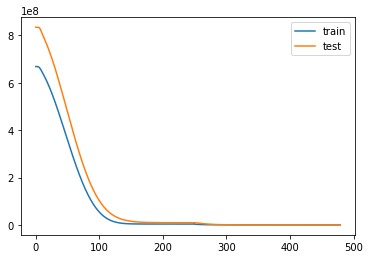

In [8]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

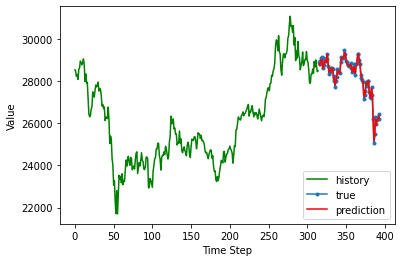

In [9]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
# plt.plot(np.arange(0, len(y_train)), sc_y.inverse_transform(y_train), 'g', label="history")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_test), marker='.', label="true")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

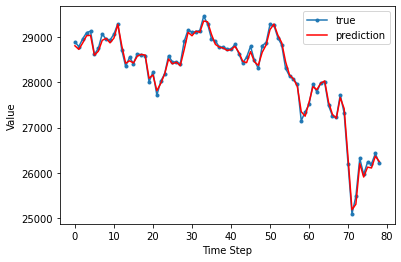

In [10]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [11]:
r2_score(y_test,y_pred)

0.9935351846009769

In [12]:
mean_absolute_percentage_error(y_test,y_pred)

0.002317070480702322

In [13]:
mean_squared_error(y_test,y_pred,squared=False)

78.04814940854544

In [14]:
x_val=data_val.drop('Prediction',1).values
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_15224/2175021245.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1).values
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


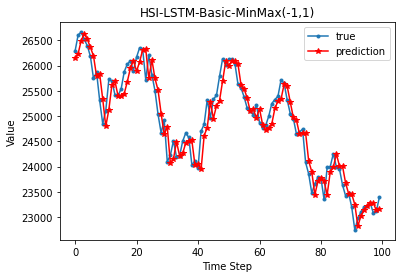

In [19]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM-Basic-MinMax(-1,1)')
plt.legend()
plt.show()

In [16]:
r2_score(y_val,y_val_pred)

0.9125437513399128

In [17]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.009604663273732187

In [18]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

297.074522103151